In [43]:
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
#import mibian
from py_vollib.black_scholes import implied_volatility
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

# 1. Read and Process the data

In [625]:
top5 = pd.read_csv("~/Downloads/2022_02_28_2023_02_28_top5.csv") #xq4gifzo0miguljf.csv")
ticker_symbol = ['AAPL','MSFT','UNH','GS','HD']
start_date = '2022-02-28'
end_date='2023-03-01'

def stock_option(top5, ticker_symbol, start_date = start_date, end_date = end_date):
    ticker_data = [yf.Ticker(i) for i in ticker_symbol]
    ticker_df = []
    for i,x in zip(ticker_symbol,ticker_data):
        data = x.history(start=start_date, end=end_date)[['Close','Dividends']]
        data['symbol'] = i[:2]
        ticker_df.append(data)
    ticker_df = pd.concat(ticker_df,axis=0).reset_index()
    ticker_df['Date'] = ticker_df['Date'].dt.date
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
    
    top5['exdate'] = pd.to_datetime(top5['exdate'])
    top5['date'] = pd.to_datetime(top5['date'])
    top5['Maturity'] = (top5['exdate']-top5['date']).dt.days/360
    top5['symbol_2'] = top5['symbol'].apply(lambda x : x[:2])
    top5['cp_flag'] = top5['cp_flag'].replace(['C', 'P'], ['call','put'])
    top5['strike_price'] = top5['strike_price']/1000
    top5['price'] = (top5['best_offer'] + top5['best_bid']) / 2
    
    top5 = pd.merge(top5,ticker_df,left_on=['date','symbol_2'],right_on=['Date','symbol'])
    return top5

top5 = stock_option(top5, ticker_symbol)

In [627]:
top5

,secid,date,symbol_x,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,div_convention,exercise_style,am_set_flag,Maturity,symbol_2,price,Date,Close,Dividends,symbol_y
0,101594,2022-02-28,AAPL 220311P135000,1,2022-03-11,2022-02-28,put,135.0,0.12,0.13,...,NaN,A,NaN,0.030556,AA,0.125,2022-02-28,163.254349,0.0,AA
1,101594,2022-02-28,AAPL 220311P139000,1,2022-03-11,2022-02-28,put,139.0,0.16,0.18,...,NaN,A,NaN,0.030556,AA,0.170,2022-02-28,163.254349,0.0,AA
2,101594,2022-02-28,AAPL 220311P140000,1,2022-03-11,2022-02-28,put,140.0,0.18,0.19,...,NaN,A,NaN,0.030556,AA,0.185,2022-02-28,163.254349,0.0,AA
3,101594,2022-02-28,AAPL 220311P141000,1,2022-03-11,2022-02-28,put,141.0,0.20,0.21,...,NaN,A,NaN,0.030556,AA,0.205,2022-02-28,163.254349,0.0,AA
4,101594,2022-02-28,AAPL 220311P142000,1,2022-03-11,2022-02-28,put,142.0,0.22,0.23,...,NaN,A,NaN,0.030556,AA,0.225,2022-02-28,163.254349,0.0,AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230243,111469,2023-02-28,UNH 250117P740000,1,2025-01-17,NaN,put,740.0,259.15,268.50,...,NaN,A,NaN,1.913889,UN,263.825,2023-02-28,467.039734,0.0,UN
2230244,111469,2023-02-28,UNH 250117P760000,1,2025-01-17,NaN,put,760.0,279.95,288.40,...,NaN,A,NaN,1.913889,UN,284.175,2023-02-28,467.039734,0.0,UN
2230245,111469,2023-02-28,UNH 250117P780000,1,2025-01-17,NaN,put,780.0,299.70,308.50,...,NaN,A,NaN,1.913889,UN,304.100,2023-02-28,467.039734,0.0,UN
2230246,111469,2023-02-28,UNH 250117P800000,1,2025-01-17,NaN,put,800.0,319.05,328.05,...,NaN,A,NaN,1.913889,UN,323.550,2023-02-28,467.039734,0.0,UN


In [324]:
# try to calculate the implied volatility which is NA
is_na = top5['impl_volatility'].isna()
# just try to use the ffill and bfill volatility to use as guess volatility
top5['impl_volatility'] = top5.groupby(['cp_flag','symbol_y'])['impl_volatility'].fillna(method='bfill').fillna(method='ffill')
top5 = top5[is_na] # only calculate the NA
top5.to_csv("~/Downloads/option_before.csv")
# RUN the R Code

In [325]:
# use the data from R Code
data = pd.read_csv("~/Downloads/option.csv")
data[~data['ImpliedVolatility'].isna()]
# not too much but has culculated some
# and maybe we can just ffill it if they are really close

,X,secid,date,symbol_x,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,...,exercise_style,am_set_flag,symbol_2,Date,Close,Dividends,symbol_y,Maturity,price,ImpliedVolatility
0,0,101594,2023-02-01,AAPL 230203C100000,1,2023-02-03,2023-02-01,call,100.0,45.30,...,A,NaN,AA,2023-02-01,144.437332,0.0,AA,0.005556,45.450,3.365026
1,1,101594,2023-02-01,AAPL 230203C105000,1,2023-02-03,2023-02-01,call,105.0,40.30,...,A,NaN,AA,2023-02-01,144.437332,0.0,AA,0.005556,40.450,3.003258
2,2,101594,2023-02-01,AAPL 230203C109000,1,2023-02-03,NaN,call,109.0,36.30,...,A,NaN,AA,2023-02-01,144.437332,0.0,AA,0.005556,36.425,2.704375
3,3,101594,2023-02-01,AAPL 230203C110000,1,2023-02-03,2023-02-01,call,110.0,35.30,...,A,NaN,AA,2023-02-01,144.437332,0.0,AA,0.005556,35.450,2.652839
4,4,101594,2023-02-01,AAPL 230203C111000,1,2023-02-03,2023-01-25,call,111.0,34.30,...,A,NaN,AA,2023-02-01,144.437332,0.0,AA,0.005556,34.450,2.583925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23291,172142,111469,2023-02-28,UNH 230406C610000,1,2023-04-06,NaN,call,610.0,0.00,...,A,NaN,UN,2023-02-28,467.039764,0.0,UN,0.102778,1.800,0.497731
23292,172143,111469,2023-02-28,UNH 230406C620000,1,2023-04-06,NaN,call,620.0,0.00,...,A,NaN,UN,2023-02-28,467.039764,0.0,UN,0.102778,1.800,0.521458
23293,172144,111469,2023-02-28,UNH 230406C630000,1,2023-04-06,NaN,call,630.0,0.00,...,A,NaN,UN,2023-02-28,467.039764,0.0,UN,0.102778,1.800,0.544565
23313,172200,111469,2023-02-28,UNH 230421C250000,1,2023-04-21,NaN,call,250.0,222.85,...,A,NaN,UN,2023-02-28,467.039764,0.0,UN,0.144444,225.975,1.248462


In [557]:
# build staddle of the top 5
top5_copy = top5.groupby(['symbol_y','Date','exdate','strike_price']).apply(lambda x : pd.Series([x['price'].sum(),x['impl_volatility'].mean()],index=['price','IV']) if (len(x[x['cp_flag']=='put'])>=1 and len(x[x['cp_flag']=='call'])>=1) else pd.Series([np.nan,np.nan],index=['price','IV']))
top5_copy['avg_price'] = top5_copy['price'].groupby(['symbol_y','exdate','strike_price']).pct_change()
top5_copy

price        IV  avg_price
symbol_y Date       exdate     strike_price                              
AA       2023-02-01 2023-02-03 50.0           95.380       NaN        NaN
                               55.0           90.380       NaN        NaN
                               60.0           85.380       NaN        NaN
                               65.0           80.430       NaN        NaN
                               70.0           75.430       NaN        NaN
...                                              ...       ...        ...
UN       2023-02-28 2025-01-17 740.0         271.525  0.213272   0.019812
                               760.0         290.775  0.214786   0.019369
                               780.0         309.550  0.214283   0.017671
                               800.0         327.775  0.210988   0.015963
                               820.0         346.620  0.204909   0.017122

[86425 rows x 3 columns]

In [576]:
# read the index option data
options_data = pd.read_csv("~/Downloads/shril26ejyyyoum8.csv")
futures_data = yf.download("YM=F", start="2022-02-28", end="2023-02-28")

options_data['exdate'] = pd.to_datetime(options_data['exdate'])
options_data['date'] = pd.to_datetime(options_data['date'])
options_data['time_to_expiry'] = (options_data['exdate'] - options_data['date']).dt.days
options_data = options_data.rename(columns={'date':'Date'})
options_data = options_data[['Date','exdate','cp_flag','strike_price','time_to_expiry','best_bid','best_offer','impl_volatility']]

indx_data = pd.merge(options_data,futures_data,on = 'Date')
indx_data['strike_price'] = indx_data['strike_price']/10
indx_data['strike_distance'] = np.abs(indx_data['Adj Close'] - indx_data['strike_price'])
indx_data_copy = indx_data
indx_data['option_close'] = (indx_data['best_bid'] + indx_data['best_offer']) / 2
indx_data

[*********************100%%**********************]  1 of 1 completed


,Date,exdate,cp_flag,strike_price,time_to_expiry,best_bid,best_offer,impl_volatility,Open,High,Low,Close,Adj Close,Volume,strike_distance,option_close
0,2023-02-01,2023-02-03,C,32900.0,2,9.35,14.30,NaN,34132.0,34407.0,33624.0,34148.0,34148.0,207744,1248.0,11.825
1,2023-02-01,2023-02-03,C,33000.0,2,8.40,13.35,NaN,34132.0,34407.0,33624.0,34148.0,34148.0,207744,1148.0,10.875
2,2023-02-01,2023-02-03,C,33100.0,2,7.40,12.35,NaN,34132.0,34407.0,33624.0,34148.0,34148.0,207744,1048.0,9.875
3,2023-02-01,2023-02-03,C,33200.0,2,8.70,9.25,0.262291,34132.0,34407.0,33624.0,34148.0,34148.0,207744,948.0,8.975
4,2023-02-01,2023-02-03,C,33300.0,2,7.75,8.30,0.271109,34132.0,34407.0,33624.0,34148.0,34148.0,207744,848.0,8.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22595,2023-02-27,2025-12-19,P,52000.0,1026,137.00,153.00,NaN,32816.0,33211.0,32783.0,32909.0,32909.0,156501,19091.0,145.000
22596,2023-02-27,2025-12-19,P,54000.0,1026,154.00,170.00,NaN,32816.0,33211.0,32783.0,32909.0,32909.0,156501,21091.0,162.000
22597,2023-02-27,2025-12-19,P,56000.0,1026,171.00,187.00,NaN,32816.0,33211.0,32783.0,32909.0,32909.0,156501,23091.0,179.000
22598,2023-02-27,2025-12-19,P,58000.0,1026,189.00,205.00,NaN,32816.0,33211.0,32783.0,32909.0,32909.0,156501,25091.0,197.000


In [585]:
# build staddle of the index
indx_data_copy = indx_data.groupby(['Date','exdate','strike_price']).apply(lambda x : pd.Series([x['option_close'].sum(),x['impl_volatility'].mean()],index=['price','IV']) if (len(x[x['cp_flag']=='P'])>=1 and len(x[x['cp_flag']=='C'])>=1) else pd.Series([np.nan,np.nan],index=['price','IV']))
indx_data_copy['avg_price'] = indx_data_copy['price'].groupby(['exdate','strike_price']).pct_change()
indx_data_copy

price        IV  avg_price
Date       exdate     strike_price                              
2023-02-01 2023-02-03 32900.0        11.895  0.358665        NaN
                      33000.0        10.960  0.344616        NaN
                      33100.0         9.980  0.331070        NaN
                      33200.0         9.120  0.293400        NaN
                      33300.0         8.220  0.293689        NaN
...                                     ...       ...        ...
2023-02-27 2025-12-19 52000.0       149.800       NaN        0.0
                      54000.0       166.800       NaN        0.0
                      56000.0       183.800       NaN        0.0
                      58000.0       201.800       NaN        0.0
                      60000.0       218.800       NaN        0.0

[11300 rows x 3 columns]

# 2. Get the dirty correlation and the position

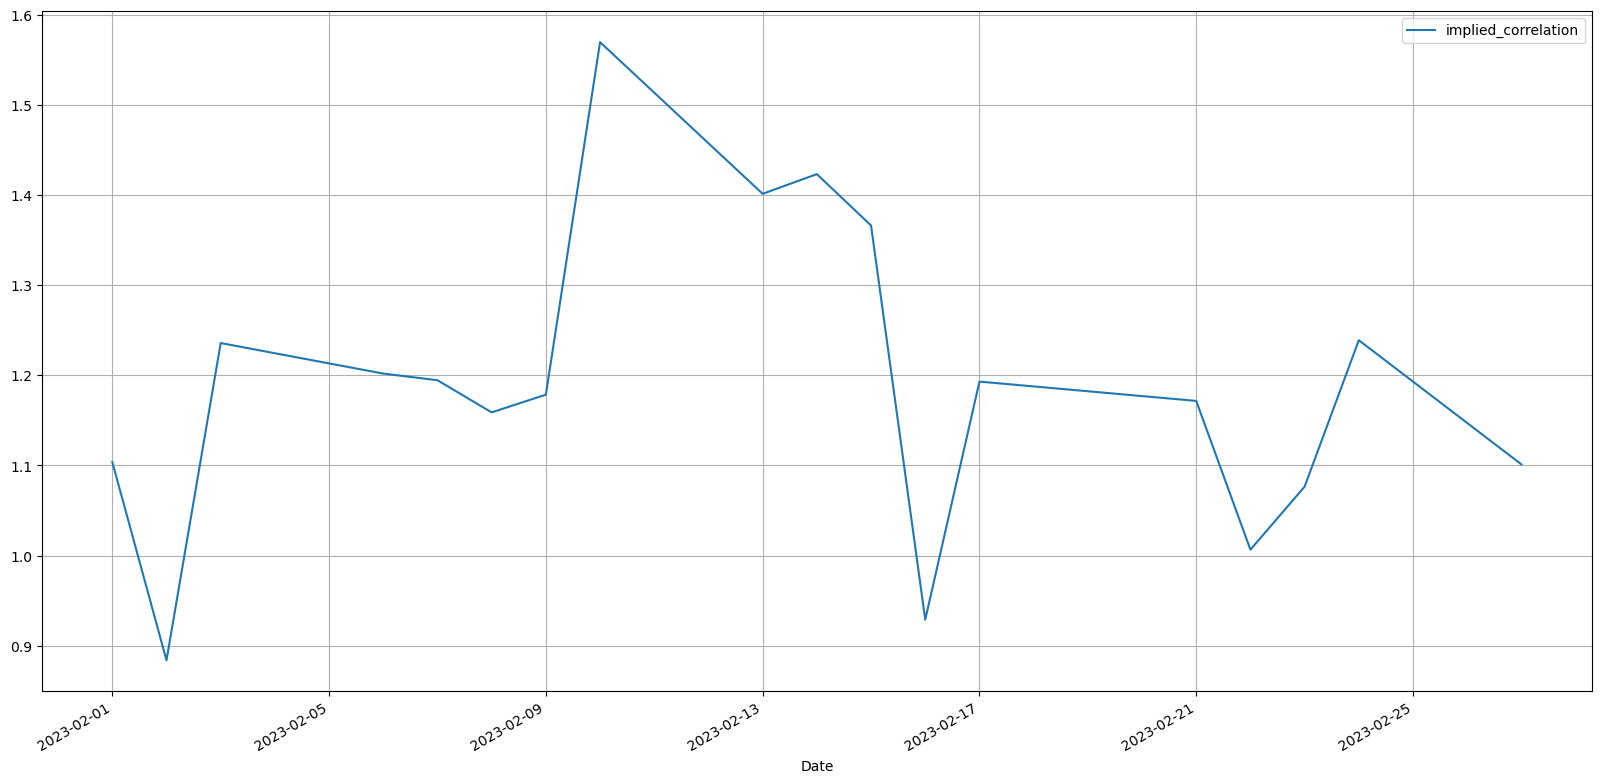

In [563]:
def implied_dirty_correlation():
    dowjones_IV = indx_data_copy.groupby(['Date'])['IV'].mean().to_frame()
    top5_IV = top5_copy.groupby(['Date'])['IV'].mean().to_frame()
    return (dowjones_IV/top5_IV)**2

df = implied_dirty_correlation()
df = df.rename(columns={'IV': 'implied_correlation'})
df.plot( grid = True , figsize = (20,10))
plt.show()

In [564]:
#-1 short the index and long the stocks
#1 long the index and short the stocks
df['position'] = df.apply(lambda x: -1 if x['implied_correlation']>1 else ( 1 if x['implied_correlation']<0.5 else 0),axis = 1)
df 

,implied_correlation,position
Date,,
2023-02-01,1.103835,-1
2023-02-02,0.883795,0
2023-02-03,1.235879,-1
2023-02-06,1.202000,-1
2023-02-07,1.194604,-1
2023-02-08,1.158948,-1
2023-02-09,1.178621,-1
2023-02-10,1.569823,-1
2023-02-13,1.401499,-1


In [587]:
top5_return = pd.merge(top5_copy,df,on="Date")
indx_return = pd.merge(indx_data_copy,df,on="Date")

# 3. Get the Return

<Axes: xlabel='Date'>

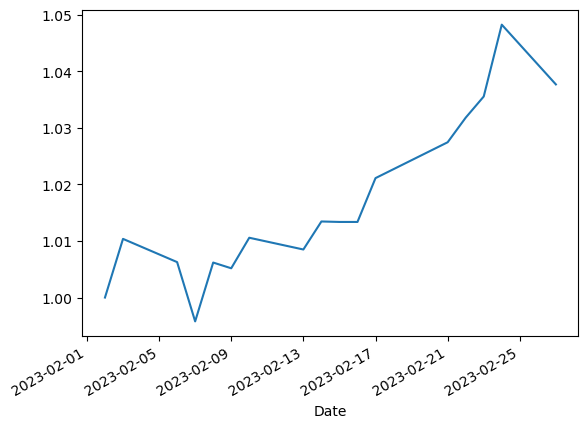

In [607]:
strategy_return = (top5_return['avg_price'] * top5_return['position']).groupby('Date').mean()-(indx_return['avg_price'] * indx_return['position']).groupby('Date').mean()
np.cumprod(1+strategy_return).plot()

# 4. 

In [604]:
def performance(strategy_returns, benchmark_returns, window = 5):
    # Annualized return
    annual_return = strategy_returns['returns'].mean() * 252
    
    # Annualized volatility
    annual_volatility = strategy_returns['returns'].std() * np.sqrt(252)
    
    # Sharpe ratio, assuming risk-free rate is 0 for simplicity
    sharpe_ratio = annual_return / annual_volatility
    
    # Max drawdown in one day
    max_drawdown = strategy_returns['returns'].min()
    
    # Cumulative returns with a benchmark plot
    strategy_returns['cumulative'] = (1 + strategy_returns['returns']).cumprod()
    benchmark_returns['cumulative'] = (1 + benchmark_returns['dow_jones_returns']).cumprod()
    
    # Rolling volatility and rolling sharpe ratio plot
    strategy_returns['rolling_vol'] = strategy_returns['returns'].rolling(window).std() * np.sqrt(window)
    strategy_returns['rolling_sharpe'] = strategy_returns['returns'].rolling(window).mean() / strategy_returns['returns'].rolling(window).std()

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(strategy_returns['cumulative'], label='Strategy')
    plt.plot(benchmark_returns['cumulative'], label='Benchmark')
    plt.legend()
    plt.title('Cumulative Returns')
    plt.show()
    
    # Plot rolling volatility
    plt.figure(figsize=(12, 6))
    plt.plot(strategy_returns['rolling_vol'], label='Rolling Volatility')
    plt.legend()
    plt.title('Rolling Volatility (1 Year)')
    plt.show()

    # Plot rolling Sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.plot(strategy_returns['rolling_sharpe'], label='Rolling Sharpe Ratio')
    plt.legend()
    plt.title('Rolling Sharpe Ratio (1 Year)')
    plt.show()
    
    # Regression daily return on daily return of Dow Jones, portfolio beta
    import statsmodels.api as sm
    
    # Assume 'dow_jones_returns' is a column in your DataFrame
    X = sm.add_constant(benchmark_returns['dow_jones_returns'])  # Adds a constant term to the predictor
    est = sm.OLS(strategy_returns['returns'], X).fit()
    strategy_beta = est.params['dow_jones_returns']
    
    # Performance alpha (return - beta * Dow Jones return)
    strategy_alpha = annual_return - (strategy_beta * benchmark_returns['dow_jones_returns'].mean() * 252)
    
    print(f'Annual Return: {annual_return}')
    print(f'Annual Volatility: {annual_volatility}')
    print(f'Sharpe Ratio: {sharpe_ratio}')
    print(f'Max Drawdown: {max_drawdown}')
    print(f'Portfolio Beta: {strategy_beta}')
    print(f'Alpha: {strategy_alpha}')

In [621]:
pd.read_csv("~/Downloads/strategy_return_marchtojuly_2020.csv").rename(columns={'0':'returns'})

,Date,returns
0,2020-01-02,NaN
1,2020-01-03,-0.016376
2,2020-01-06,0.010865
3,2020-01-07,0.004926
4,2020-01-08,0.011634
...,...,...
120,2020-06-24,-0.036338
121,2020-06-25,0.038167
122,2020-06-26,-0.016436
123,2020-06-29,0.015947


In [615]:
strategy_return
dow_jones = yf.Ticker("^DJI").history(start=start_date, end=end_date)
benchmark_returns = pd.DataFrame(dow_jones['Close'].pct_change().rename('dow_jones_returns'))
strategy_returns = pd.DataFrame(strategy_return.rename('returns'))
is_na = (benchmark_returns['dow_jones_returns'].isna())|(strategy_returns['returns'].isna())
performance(strategy_returns[~is_na], benchmark_returns[~is_na])

TypeError: Cannot join tz-naive with tz-aware DatetimeIndex